In [17]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

# Import geomap of the Netherlands
mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
mapdf = mapdf[mapdf["H2O"] == "NEE"]
mapdf.sort_values("GM_NAAM", inplace=True)
mapdf = mapdf.reset_index(drop=True)
print(mapdf.columns)

# Compute distances between all municipalities
mapdf['GEO_CENTROID'] = mapdf.centroid
centres = mapdf['GEO_CENTROID']
n_mun = mapdf.shape[0]

# dist_matrix = np.zeros(shape=(n_mun, n_mun))
# for i in range(0, n_mun):
#     dist_matrix[i] = centres.distance(centres[i])

# Compute mobility based gravity model, without distances
population = mapdf['AANT_INW']
mob_matrix = np.zeros(shape=(n_mun, n_mun))
for i in range(0, n_mun):
    for j in range(0, n_mun):
        if i != j:
            mob_matrix[i,j] = population[i] * population[j]

# Import original data to normalize to
df_mobmat_freq = pd.read_csv('Data/Mob_grav_freq.csv', delimiter=',')
mobmat_freq = df_mobmat_freq[df_mobmat_freq.columns[1:]].to_numpy()

df_mobmat_inc = pd.read_csv('Data/Mob_grav_inc.csv', delimiter=',')
mobmat_inc = df_mobmat_inc[df_mobmat_inc.columns[1:]].to_numpy()

# Normalize row sums to original data, so total amount traveled per municipality is the same.
mob_matrix_freq = np.zeros(shape=(n_mun, n_mun))
mob_matrix_inc = np.zeros(shape=(n_mun, n_mun))
for i in range(n_mun):
    diff_freq = np.nansum(mob_matrix[i]) / np.nansum(mobmat_freq[i])
    mob_matrix_freq[i] = mob_matrix[i] / diff_freq

    diff_inc  = np.nansum(mob_matrix[i]) / np.nansum(mobmat_inc[i])
    mob_matrix_inc[i] = mob_matrix[i] / diff_inc

# Save the new matrix
path = os.getcwd() + '/Data/'
np.save(path + 'Randomized_mob_grav_freq', mob_matrix_freq)
np.save(path + 'Randomized_mob_grav_inc', mob_matrix_inc)

Index(['GM_CODE', 'GM_NAAM', 'H2O', 'OAD', 'STED', 'BEV_DICHTH', 'AANT_INW',
       'AANT_MAN', 'AANT_VROUW', 'P_00_14_JR',
       ...
       'AV20PODIUM', 'AF_MUSEUM', 'AV5_MUSEUM', 'AV10MUSEUM', 'AV20MUSEUM',
       'JRSTATCODE', 'JAAR', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object', length=205)


In [9]:
import os


folder_to_clear = "D:/University/thesis/covid-gravity-model/Data/Model_V1/Data/High/Seed_5"

for demo in range(0, 11):
    path = folder_to_clear + '/Runs_ref_3_3_5_' + str(demo)
    for run in range(0, 10):
        os.remove(path + '/Contacts_per_agent_' + str(run) + '.npy')


In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib
import pandas as pd
import numpy as np
import os

ppl_per_agent = 100

path_gem_names = os.getcwd() + '/Data/Gem_alfabetisch_2018.csv'

DF_Gem = pd.read_csv(path_gem_names, delimiter=';', encoding='latin-1')
UniLocs = np.unique(DF_Gem.Gemeentenaam)
UniIDs = [list(DF_Gem.GemeentecodeGM[DF_Gem.Gemeentenaam == i])[0] for i in UniLocs]

path_demo = os.getcwd() + '/Data/DemographicMatrix.csv'

DF_Demo = pd.read_csv(path_demo, delimiter=',')
DemoIDs = np.array(DF_Demo['Unnamed: 0'])
DemoMat_unsorted = np.array(DF_Demo[DF_Demo.keys()[1:]])
DemoMat_sorted = []
for ID in UniIDs:
    DemoMat_sorted.append(DemoMat_unsorted[DemoIDs == int(ID.lstrip('GM'))])
DemoMat = (np.array(DemoMat_sorted)/ppl_per_agent).astype(int)[:, 0]

DemoFractionsMat = np.zeros(shape=DemoMat.shape)
for i in range(0, DemoMat.shape[0]):
    DemoFractionsMat[i] = DemoMat[i] / np.sum(DemoMat[i])



# Useful functions
def create_spatial_plot(data_per_municipality, title, legend_label):
    '''
    Plot map with data per municipality
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_val = np.max(data_per_municipality)

    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    fig.suptitle(title)
    ax.axis('off')

    mapdf.insert(0, 'DATA', data_per_municipality)

    mapdf.plot(ax=ax, column="DATA", 
               legend=True, legend_kwds={"label": legend_label, "orientation": "vertical"})

    plt.plot()



def create_spatial_4plots(data_per_municipality, title, legend_label):
    '''
    Plot 4 maps, evenly spread out over time
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    max_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 4, figsize=(20, 8))
    fig.suptitle(title)

    mapdf.insert(0, 'DATA_QUARTER', data_per_municipality[int(max_time/4)])
    mapdf.insert(0, 'DATA_HALF', data_per_municipality[int(max_time/2)])
    mapdf.insert(0, 'DATA_3QUARTER', data_per_municipality[int(max_time*3/4)])
    mapdf.insert(0, 'DATA_MAXTIME', data_per_municipality[max_time-1])

    mapdf.plot(ax=axs[0], column="DATA_QUARTER", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[1], column="DATA_HALF", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[2], column="DATA_3QUARTER", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[3], column="DATA_MAXTIME", norm=matplotlib.colors.LogNorm(1,max_val))


    axs[0].set_title('t=' + str(int(max_time/4)))
    axs[1].set_title('t=' + str(int(max_time/2)))
    axs[2].set_title('t=' + str(int(max_time*3/4)))
    axs[3].set_title('t=' + str(int(max_time-1)))

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    axs[3].axis('off')

    mappable = cm.ScalarMappable(
        norm=mcolors.Normalize(1, max_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


# DAILY PLOT FOR 1 WEEK

def create_spatial_7plots(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot a daily map for 1 week
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = day + 1
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), norm=matplotlib.colors.LogNorm(1, max_legend_val))
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    mappable = cm.ScalarMappable(
        norm=matplotlib.colors.LogNorm(1, max_legend_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


def create_spatial_7plots3(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot 7 maps, spaced 3 days apart
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = (day + 1) * 3
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), norm=matplotlib.colors.LogNorm(1, max_legend_val))
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    mappable = cm.ScalarMappable(
        norm=matplotlib.colors.LogNorm(1, max_legend_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()

def create_spatial_7plots3_linear(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot 7 maps, spaced 3 days apart
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])
    min_legend_val = np.min(data_per_municipality[max_time-1])

    print(max_legend_val)
    print(min_legend_val)

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = (day + 1) * 3
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), legend=True)
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    plt.tight_layout()
    plt.plot()


def combine_runs_avg(all_run_data, padding=0.000001):
    merged_data = np.zeros(shape= all_run_data[0].shape)
    for i in range (0, len(all_run_data)):
        merged_data = merged_data + all_run_data[i]
    merged_data = (merged_data / len(all_run_data)) + padding
    return merged_data

def combine_demos_weighted(municipality_id, demo_run_data, padding=0.000001):
    fracs = DemoFractionsMat[municipality_id]
    merged_data = np.zeros(shape= demo_run_data[0].shape)
    for i in range (0, len(demo_run_data)):
        weighted = fracs[i] * demo_run_data[i]
        merged_data = merged_data + weighted
    merged_data = merged_data + padding
    return merged_data


C:\Users\Larsk\AppData\Local\Temp\ipykernel_944\2440445162.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Larsk\AppData\Local\Temp\ipykernel_944\2440445162.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Larsk\AppData\Local\Temp\ipykernel_944\2440445162.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


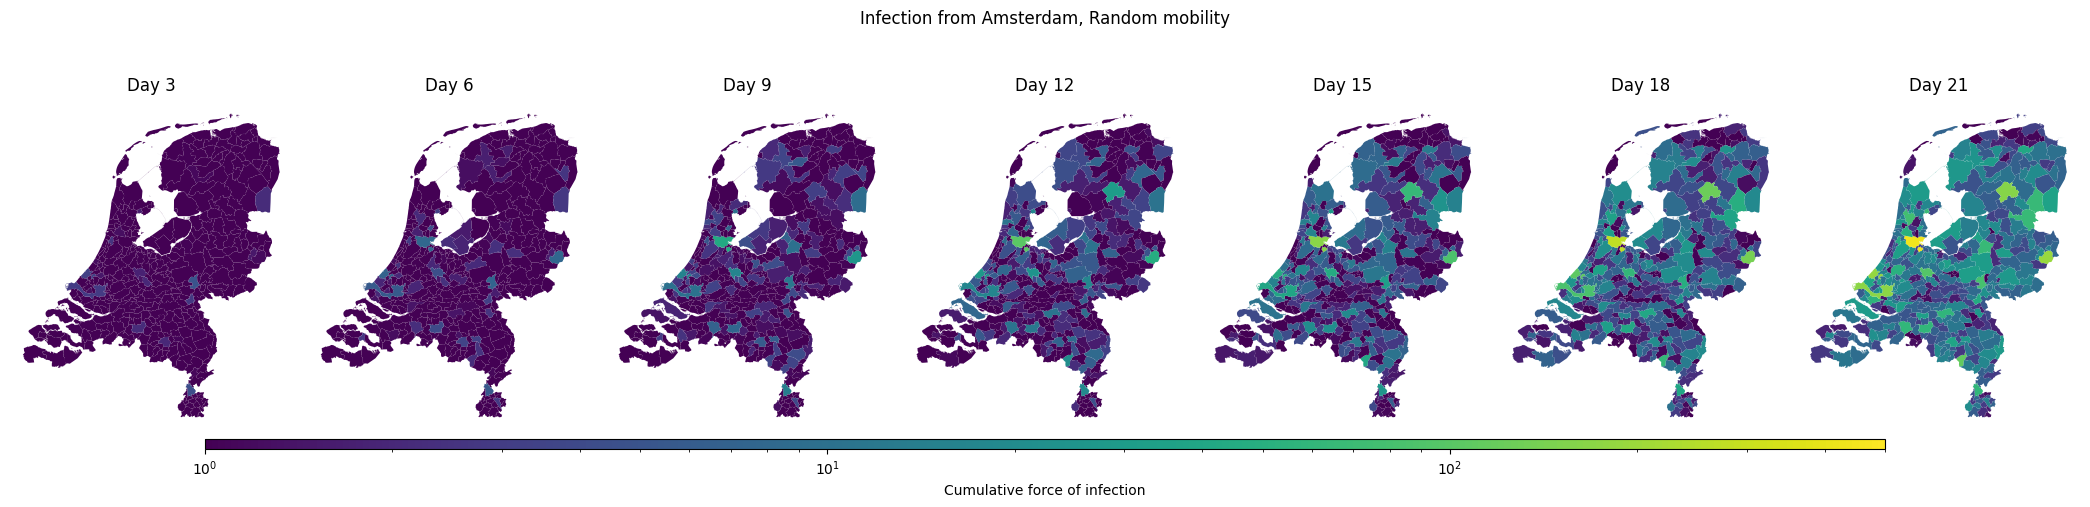

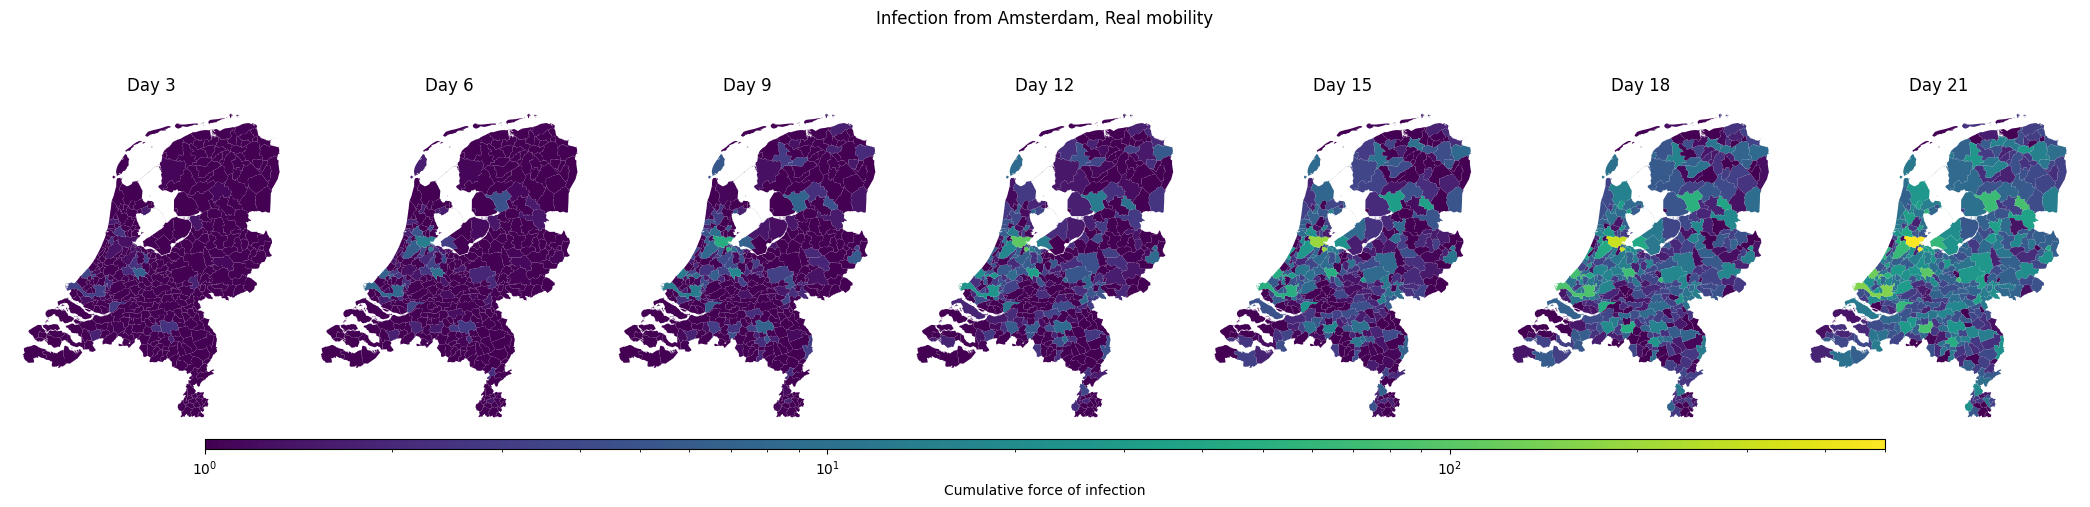

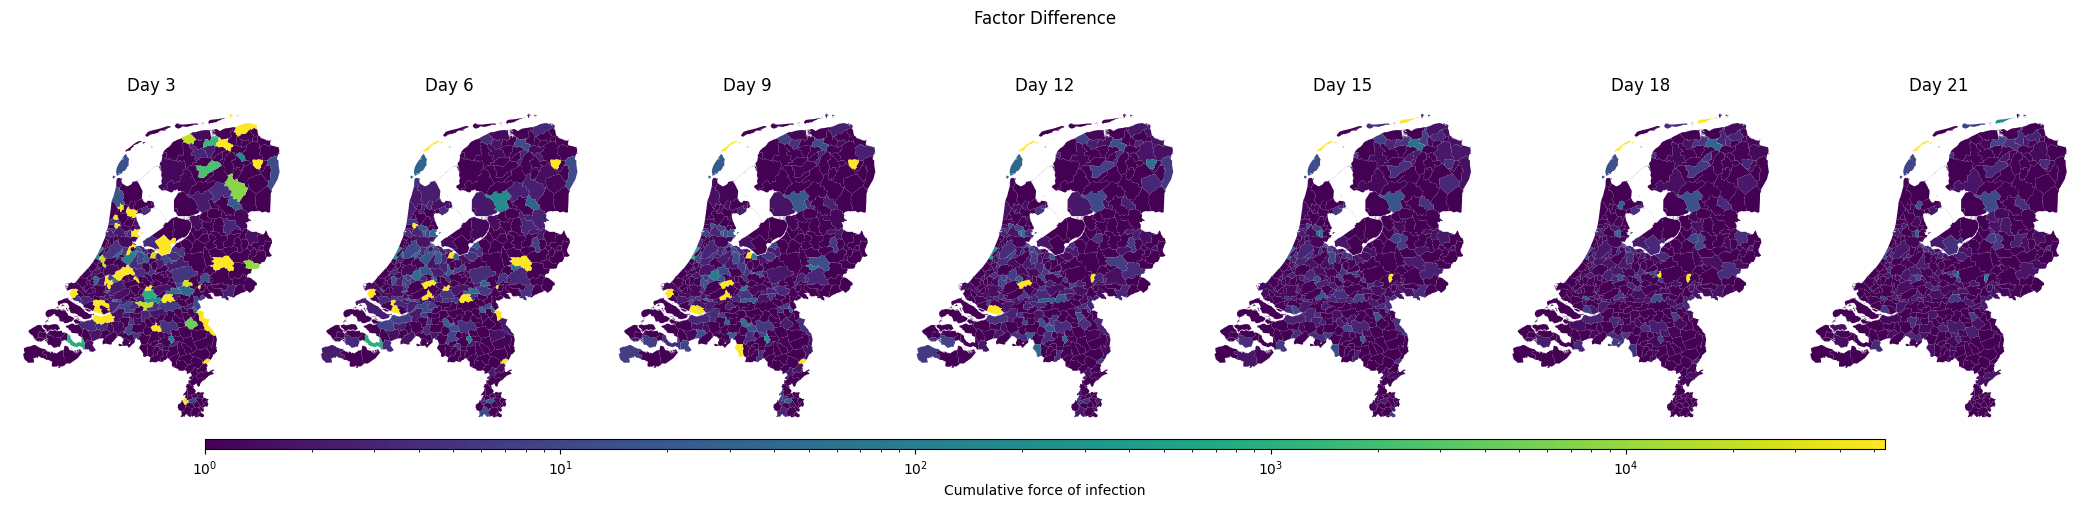

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import os

groundzero = np.where(UniLocs == 'Amsterdam')[0][0]

path_ref = os.getcwd() + '/Data/Model_V1/Data/High/Seed_8'
path_rnd = os.getcwd() + '/Data/Model_V1/Data/High/Seed_11'

title = 'Randomized gravity model, Amsterdam, demo group '
all_demo_data_rnd = []
all_demo_data_ref = []
all_demo_data_factor = []
for demo in range(0, 11):
    #avg rnd model runs
    rnd_data = []
    for run in range(0, 3):
        foi_data_per_municipality = np.load(path_rnd + '/Runs_ref_4.6_100_5_risk17_' + str(demo) + '/Infection_Pressure_' + str(run) + '.npy')
        rnd_data.append(foi_data_per_municipality)
    avg_rnd_data_per_municipality = combine_runs_avg(rnd_data, 0)
    all_demo_data_rnd.append(avg_rnd_data_per_municipality)

    # avg ref model runs
    ref_data = []
    for run in range(0, 3):
        foi_data_per_municipality = np.load(path_ref + '/Runs_ref_4.6_100_5_risk17_' + str(demo) + '/Infection_Pressure_' + str(run) + '.npy')
        ref_data.append(foi_data_per_municipality)
    avg_ref_data_per_municipality = combine_runs_avg(ref_data, 0)
    all_demo_data_ref.append(avg_ref_data_per_municipality)

merged_rnd = combine_demos_weighted(groundzero, all_demo_data_rnd)
merged_ref = combine_demos_weighted(groundzero, all_demo_data_ref)

create_spatial_7plots3(merged_rnd, 500, 'Infection from Amsterdam, Random mobility', 'Cumulative force of infection')
create_spatial_7plots3(merged_ref, 500, 'Infection from Amsterdam, Real mobility', 'Cumulative force of infection')

merged_factor = np.divide(merged_ref, merged_rnd, out=np.zeros_like(merged_ref), where=merged_rnd!=0)

create_spatial_7plots3(merged_factor, None, 'Factor Difference', 'Cumulative force of infection')


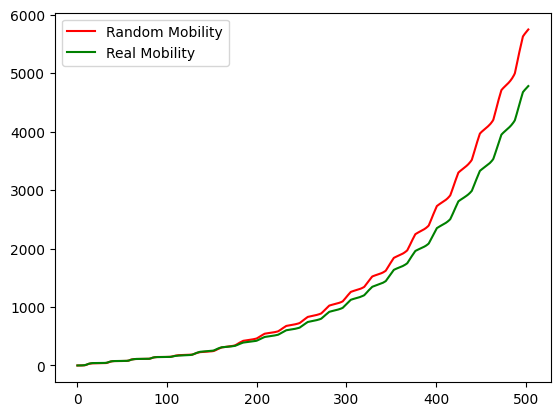

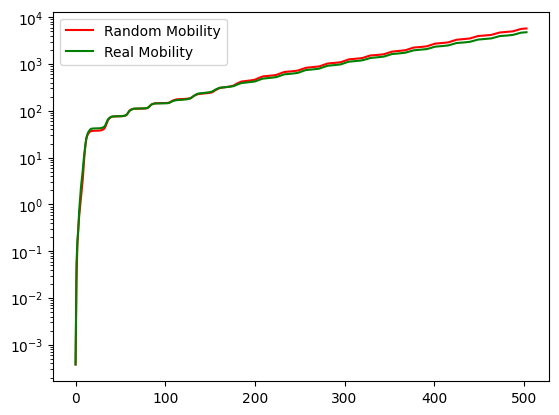

In [17]:
# Plot total force of infection as function of time

t_max = merged_rnd.shape[0]

total_foi_rnd = np.zeros(t_max)
total_foi_ref = np.zeros(t_max)
for i in range(t_max):
    total_foi_rnd[i] = np.sum(merged_rnd[i])
    total_foi_ref[i] = np.sum(merged_ref[i])

x_points = np.arange(0, t_max)
plt.plot(x_points, total_foi_rnd, color='r', label='Random Mobility')
plt.plot(x_points, total_foi_ref, color='g', label='Real Mobility')
plt.legend()
plt.show()

x_points = np.arange(0, t_max)
plt.plot(x_points, total_foi_rnd, color='r', label='Random Mobility')
plt.plot(x_points, total_foi_ref, color='g', label='Real Mobility')
plt.legend()
plt.yscale("log")
plt.show()

In [30]:
import pandas as pd
import numpy as np
import os

def load_total_infected_per_municipality(path_data, loc, group, run):
    # Load general model data
    peopleDF = pd.read_pickle(path_data + 'PeopleDF.pkl')
    extraPeopleDF = pd.read_pickle(path_data + 'ExtraPeopleDF.pkl')
    status = np.load(path_data + 'Runs_ref_4.6_100_5_risk' + str(loc) + '_' + str(group) + '/Status_' + str(run) + '.npz')
    uniLocs = np.array(pd.read_pickle(path_data + 'Gemeenten.pkl')).T[0]
    loc_to_id = {val: i for i, val in enumerate(uniLocs)}
    uniGroups = np.unique(np.array(extraPeopleDF.Group))

    extra_agents = extraPeopleDF.loc[(extraPeopleDF['Home'] == uniLocs[loc]) & (extraPeopleDF['Group'] == uniGroups[group])]
    peopleDF = pd.concat([peopleDF, extra_agents], ignore_index=True)

    # Load model output data
    timesteps = status['indptr'].shape[0] - 1
    data = status['data']
    indptr = status['indptr']
    indices = status['indices']

    # Compute for every timestep how many infected people there are in every municipality
    infected_per_municipality = np.zeros((timesteps, 380))
    for t in range(0, timesteps):
        data_t = data[indptr[t] : indptr[t + 1]]
        agents_status_t = indices[indptr[t] : indptr[t + 1]]

        infected_agents = agents_status_t[(data_t == 2) | (data_t == 3)]
        infected_agents_homes = np.array(peopleDF.loc[infected_agents]['Home'])
        for home in infected_agents_homes:
            infected_per_municipality[t, loc_to_id[home]] += 1

    return infected_per_municipality

def load_total_infected_avg_runs(path_data, loc, group, runs):
    all_data = []
    for run in range(runs):
        all_data.append(load_total_infected_per_municipality(path_data, loc, group, run))

    # Average the data
    merged_data = np.zeros(all_data[0].shape)
    for run in range(runs):
        merged_data = merged_data + all_data[run]
    merged_data = merged_data / runs
    return merged_data
    

path = os.getcwd() + '/Data/results/High/Seed_0/'

loc_name = np.array(pd.read_pickle(path + 'Gemeenten.pkl')).T[0]

risk_map = np.zeros(192)
for loc in range(192):
    infected_per_municipality = load_total_infected_avg_runs(path, loc, 3, 10)
    risk = np.sum(infected_per_municipality[503])
    risk_map[loc] = risk
    print(str(loc) +'\t' + loc_name[loc] + ':  ' + str(risk))

np.save(path + 'RiskMap', risk_map)

#create_spatial_7plots3_linear(infected_per_municipality + 0.0000000001 , None, 'haha', 'total infected')



0	's-Gravenhage:  215.3
1	's-Hertogenbosch:  195.5
2	Aa en Hunze:  109.69999999999999
3	Aalburg:  416.8
4	Aalsmeer:  265.6
5	Aalten:  155.10000000000002
6	Achtkarspelen:  151.89999999999998
7	Alblasserdam:  282.5
8	Albrandswaard:  226.0
9	Alkmaar:  191.7
10	Almelo:  143.70000000000002
11	Almere:  204.29999999999998
12	Alphen aan den Rijn:  219.59999999999997
13	Alphen-Chaam:  219.6
14	Ameland:  88.1
15	Amersfoort:  212.6
16	Amstelveen:  172.10000000000002
17	Amsterdam:  222.8
18	Apeldoorn:  169.8
19	Appingedam:  138.4
20	Arnhem:  169.6
21	Assen:  134.9
22	Asten:  192.9
23	Baarle-Nassau:  192.10000000000002
24	Baarn:  221.7
25	Barendrecht:  241.79999999999998
26	Barneveld:  182.7
27	Bedum:  426.6
28	Beek:  168.90000000000003
29	Beemster:  215.60000000000002
30	Beesel:  189.9
31	Berg en Dal:  173.0
32	Bergeijk:  226.1
33	Bergen (L.):  208.9
34	Bergen (NH.):  180.3
35	Bergen op Zoom:  199.1
36	Berkelland:  150.1
37	Bernheze:  237.50000000000003
38	Best:  252.3
39	Beuningen:  164.599999999

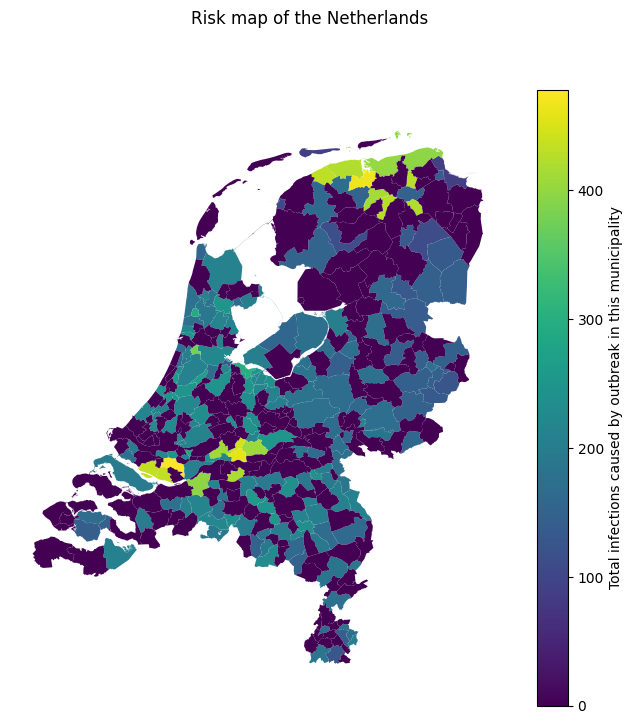

In [36]:
risk_data = np.zeros(380)
risk_per_municipality = np.load(os.getcwd() + '/Data/results/High/Seed_0/RiskMap.npy')
for i in range(192):
    risk_data[i] = risk_per_municipality[i]

create_spatial_plot(risk_data, 'Risk map of the Netherlands', 'Total infections caused by outbreak in this municipality')